In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece as spm
import torch as th

In [44]:
cif_seg = [0.0000, 0.1429, 0.4694, 0.8571, 1.0816, 1.8980, 3.1020, 3.4490, 3.6735,
        3.8163, 3.9388, 4.0816, 4.2245, 4.2857, 4.3878, 4.4898]

In [45]:
cif_without_align_seg = [0.0000, 0.2653, 0.5510, 0.6531, 0.9592, 1.9796, 3.1429, 3.3469, 3.5306,
        3.7143, 3.8367, 3.9592, 4.0612, 4.2449, 4.3265, 4.4082, 4.4898]

In [53]:
real_seg = [(0.05, 0.17), (0.17, 0.45), (0.51, 1.21), (1.75, 2.43), (2.91, 3.09), (3.17, 3.37), (3.37, 3.63), (3.63, 3.73), (3.73, 3.77), (3.77, 3.99), (4.03, 4.11), (4.11, 4.35)]
sentence = ['It', 'was', 'dinnertime,', 'and', 'we', 'started', 'looking', 'for', 'a', 'place', 'to', 'eat.']
mid = [(l + r) / 2 for l, r in real_seg]
width = [r - l for l, r in real_seg]

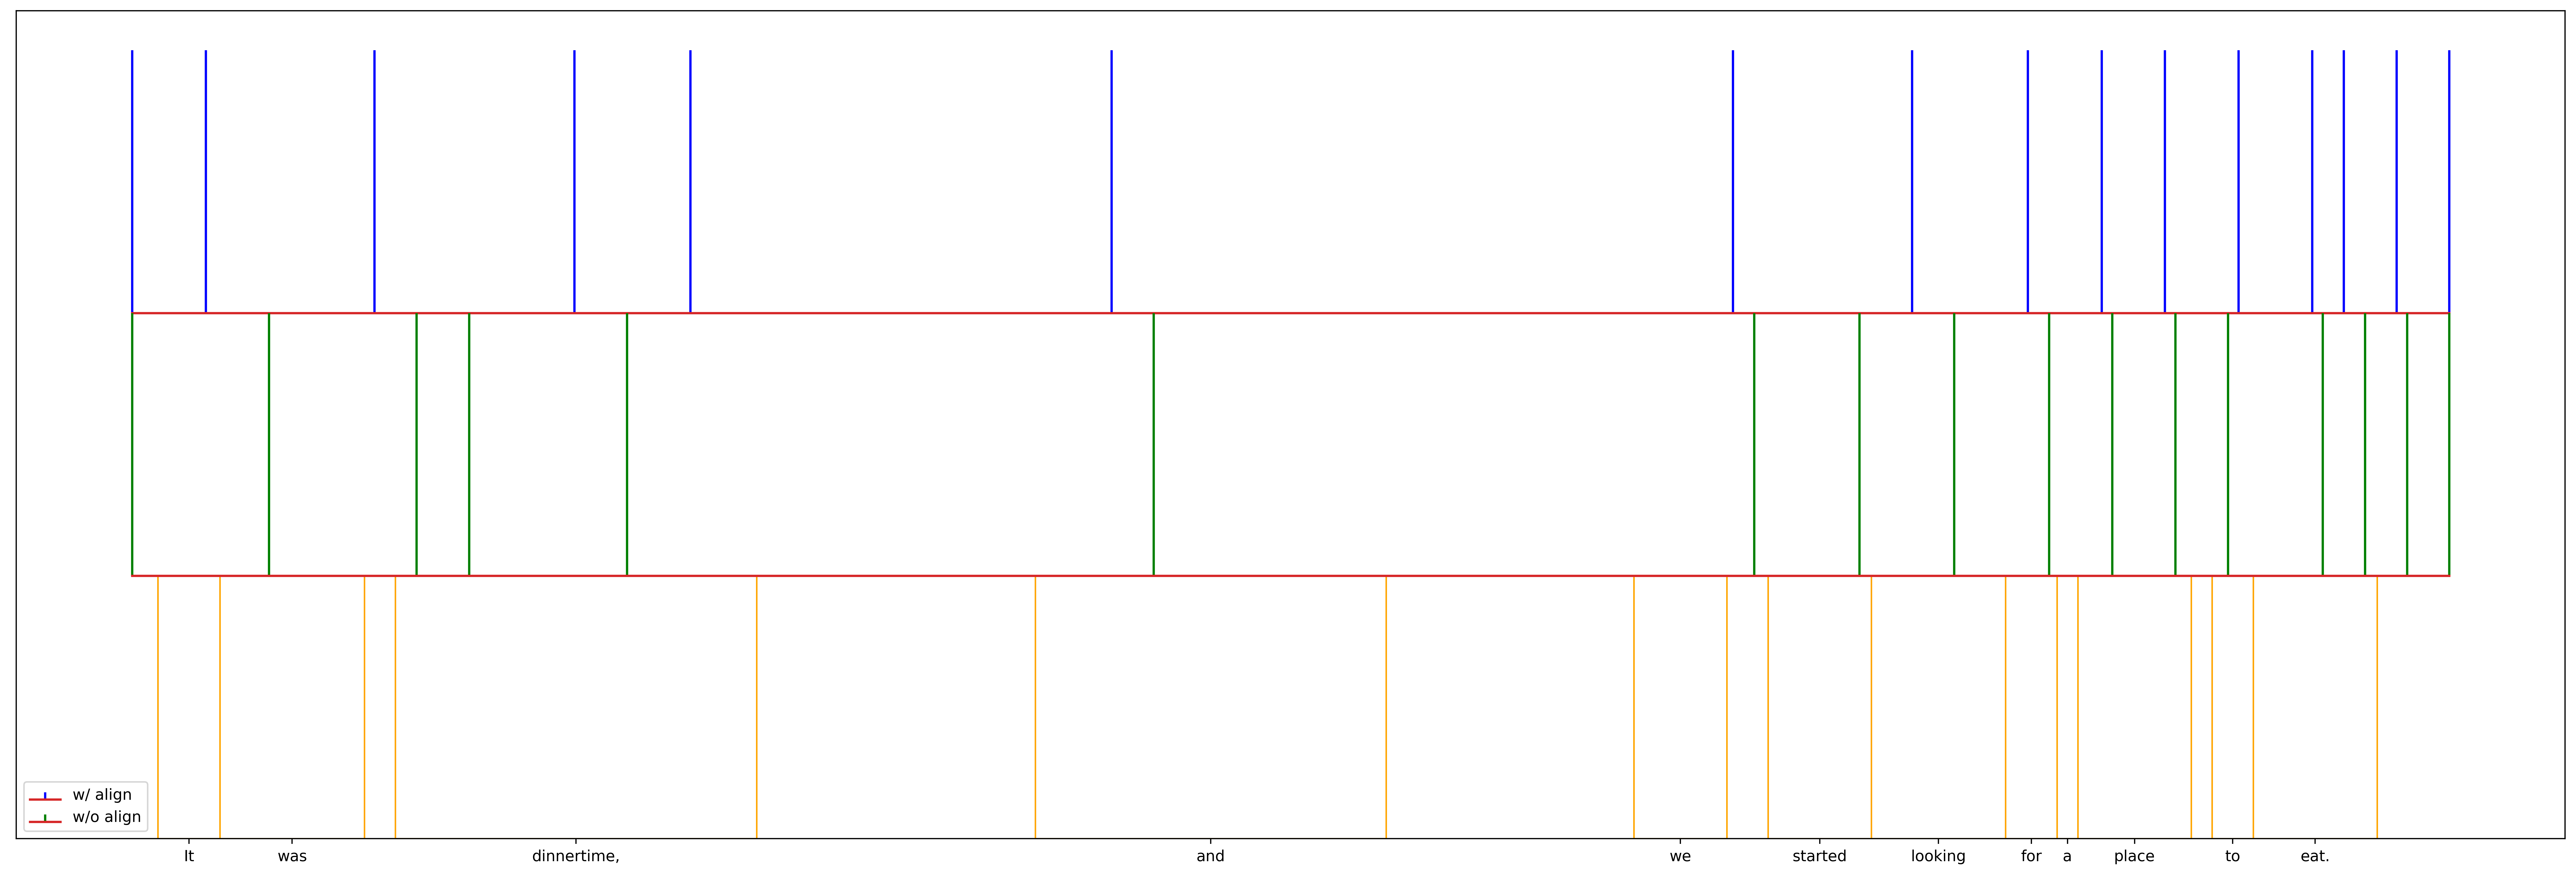

In [63]:
plt.figure(dpi=500, figsize=(30, 10))
plt.stem(cif_seg, np.ones_like(cif_seg) + 2, bottom=2, markerfmt='none', linefmt='blue', label='w/ align')
plt.stem(cif_without_align_seg, np.ones_like(cif_without_align_seg) + 1, bottom=1, markerfmt='none', linefmt='green', label='w/o align')
bar = plt.bar(mid, height=np.ones_like(mid), width=width, fc='white', ec='orange', tick_label=sentence)
plt.yticks([], [])
plt.legend()
plt.savefig('segmentation.pdf')

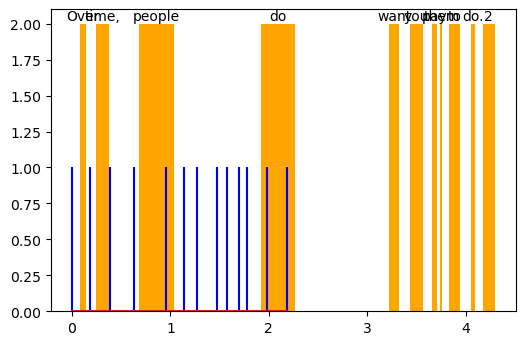

In [38]:
plt.figure(dpi=100)
plt.stem(cif_without_align_seg, np.ones_like(cif_without_align_seg), markerfmt='none', linefmt='blue')
plt.bar(mid, height=np.ones_like(mid) * 2, width=width, color='orange')
plt.bar_label(bar, labels=sentence)
plt.savefig('/tmp/cif_noalign.png')

In [68]:
bpe = spm.SentencePieceProcessor()
bpe.Load('/home/ubuntu/work/datasets/must-c/en-de/spm_unigram10000_wave_joint.model')

True

In [69]:
transcripts = th.load('/home/ubuntu/work/experiments/tmp/mt_input.pt')
st_feature = th.load('/home/ubuntu/work/experiments/tmp/st_full_feature.pt')
mt_feature = th.load('/home/ubuntu/work/experiments/tmp/mt_feature.pt')

In [70]:
st_lengths = (st_feature.max(dim=-1)[1] > 1e-5).sum(dim=-1)
mt_lengths = (transcripts != 1).sum(dim=-1)

In [71]:
st_lengths, mt_lengths

(tensor([277, 281, 280, 277, 279, 276, 279, 277], device='cuda:0'),
 tensor([31, 24, 35, 20, 32, 26, 32, 33], device='cuda:0'))

In [72]:
pairwise_dist = th.zeros(st_lengths[0], mt_lengths[0]).to('cuda')
for i in range(st_lengths[0]):
    for j in range(mt_lengths[0]):
        pairwise_dist[i, j] = th.norm(st_feature[0, i] - mt_feature[0, j])

<AxesSubplot:>

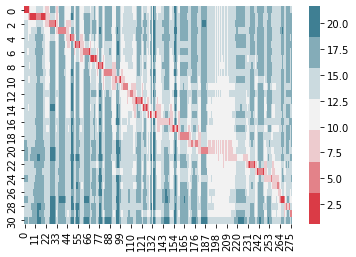

In [79]:
sns.heatmap(data=pairwise_dist.transpose(0, 1).cpu().detach().numpy(), cmap=sns.diverging_palette(10, 220, sep=40, n=7))

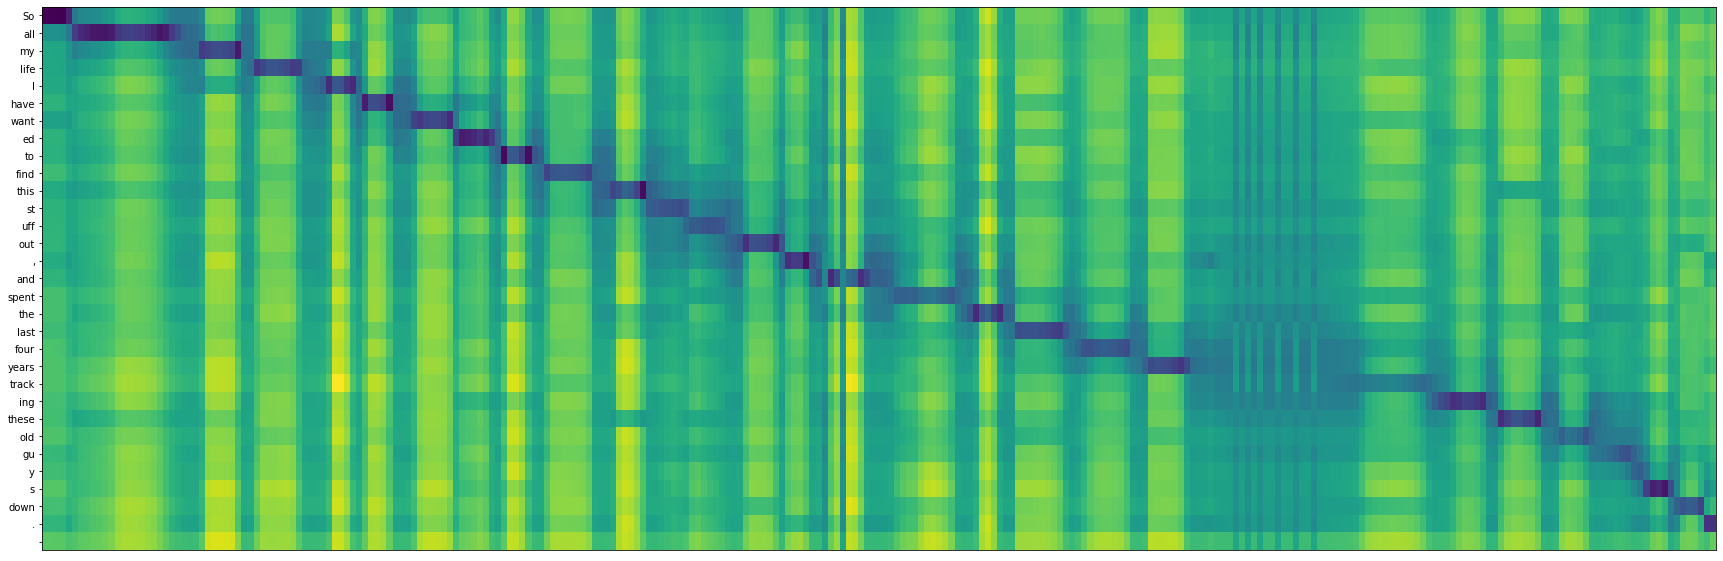

In [74]:
plt.figure(figsize=(30, 10))
plt.yticks(np.arange(mt_lengths[0].item()), [bpe.Decode(t.item()) for t in transcripts[0, :mt_lengths[0]]])
plt.xticks([], [])
plt.imshow(pairwise_dist.transpose(0, 1).cpu().detach().numpy(), aspect='auto', cmap=)
plt.savefig('alignment.pdf', format='pdf')

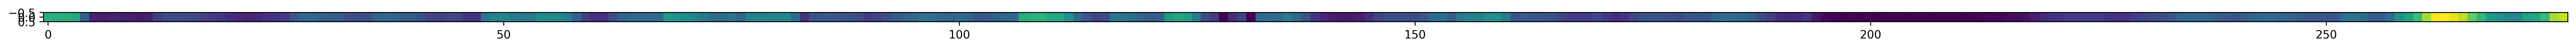

In [29]:
alpha0 = alpha[0, :st_lengths[0]].cpu().detach().numpy().reshape(1, -1)
plt.figure(dpi=500, figsize=(40, 40))
plt.imshow(alpha0)

In [17]:
bpe.DecodeIds(transcripts[0].tolist())

'So all my life I have wanted to find this stuff out, and spent the last four years tracking these old guys down.'

In [30]:
pairwise_cosdist = th.zeros(st_feature.size(0), text_embeddings.size(0)).to('cuda')
for i in range(st_feature.size(0)):
    for j in range(text_embeddings.size(0)):
        pairwise_cosdist[i, j] = (st_feature[i] * text_embeddings[j]).sum() / st_feature[i].norm() / text_embeddings[j].norm()

In [31]:
print(pairwise_cosdist.diag().mean(), pairwise_cosdist.mean())

tensor(-0.2277, device='cuda:0') tensor(-0.2070, device='cuda:0')


In [86]:
sentence = bpe.Decode([ 294,  227, 1301,   33,   20,    7,   13,  476,  100,    8, 3589,   12,
         331, 3921,  693,   55,    2,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1])
print(sentence, bpe.EncodeAsPieces(sentence), sep='\n')

So there better be a nine at the beginning of my death number.
['▁So', '▁there', '▁better', '▁be', '▁a', '▁', 'n', 'ine', '▁at', '▁the', '▁beginning', '▁of', '▁my', '▁death', '▁number', '.']


In [12]:
sentence = bpe.Decode([4914,  691,   35,  704, 2731,   10,  189,   33, 4649,    5,  939,   15,
         243,  191,   69,   89,  785,  793,   51,   32,   74,  109,    3,   21,
         758,  436,  679,   55,    2,    1,    1])
print(*bpe.EncodeAsPieces(sentence), sep=' ')

▁People ▁w r ap ▁themselves ▁in ▁their ▁be lief s , ▁and ▁they ▁do ▁it ▁so ▁t ight ly ▁that ▁you ▁can ▁ ? ? ▁t ▁set ▁them ▁free .


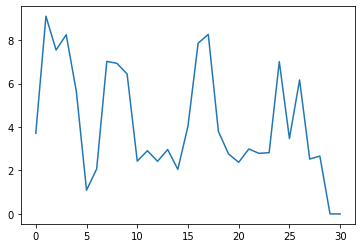

In [16]:
plt.plot([3.7129e+00, 9.1016e+00, 7.5469e+00, 8.2500e+00, 5.6289e+00, 1.0918e+00,
        2.0703e+00, 7.0234e+00, 6.9336e+00, 6.4414e+00, 2.4316e+00, 2.9102e+00,
        2.4238e+00, 2.9648e+00, 2.0508e+00, 4.0430e+00, 7.8594e+00, 8.2656e+00,
        3.7969e+00, 2.7578e+00, 2.3770e+00, 2.9902e+00, 2.7891e+00, 2.8203e+00,
        7.0117e+00, 3.4707e+00, 6.1680e+00, 2.5273e+00, 2.6621e+00, 6.7949e-05,
        6.7949e-05])
plt.savefig('/tmp/align.png')